# RENT applied to a binary classification problem

This Jupyter notebook illustrates how to apply RENT to your data for feature selection with a *binary classification* problem. It is also complimentary to the manscript published at arXiv.org.

[RENT -- Repeated Elastic Net Technique for Feature Selection](https://arxiv.org/abs/2009.12780)

For an example on how to use RENT for feature selection on a **regression problem**, please have a look this [Jupyter Notebook](https://github.com/NMBU-Data-Science/RENT/blob/master/src/RENT/Regression_example.ipynb).

## Content

1. [Load Wisconsin Breast Cancer dataset](#Load-Wisconsin-Breast-Cancer-dataset)
2. [Prepare data for variable selection using RENT](#Prepare-data-for-variable-selection-using-RENT)
2. [Define RENT ensemble for binary classification](#Define-RENT-ensemble-for-binary-classification)
3. [Train RENT ensemble and inspect results](#Train-RENT-ensemble-and-inspect-results)
4. [Set selection criteria cutoffs](#Set-selection-criteria-cutoffs)
5. [Investigation of class predictions](#Investigation-of-class-predictions)
6. [Check performance using only selected features](#Check-performance-using-only-selected-features)
7. [Feasibility study regarding the features selected by RENT](#Feasibility-study-regarding-the-features-selected-by-RENT)

---

First import needed modules and apply some settings to the Jupyter notebook for better visualisation of results.

In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 2000)
import RENT

import warnings
warnings.filterwarnings("ignore")

### Load Wisconsin Breast Cancer dataset

Now load the data from sciki-learn, store it in a pandas DataFrame and split it into a training and test set.

In [2]:
from sklearn.datasets import load_breast_cancer

wisconsin = load_breast_cancer()
data = pd.DataFrame(wisconsin.data)
data.columns = wisconsin.feature_names
target = wisconsin.target

In [3]:
data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Prepare data for variable selection using RENT

First split the data into a training and test data.

In [4]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(data, target, random_state=0, shuffle=True)

### Define RENT ensemble for binary classification

**The main idea**

Using the RENT approach we will train an **ensemble of unique models** based on **unique subsets** of the training data. Since each model is trained on a unique subset, all models will be slightly different from each other and elastic net regularisation **may select a different subset of features for each model**. 

RENT investigates **how consistenly elastic net selects features** across all unique models by analysing distributions of the weight sizes of each feature. Using specific thresholds or cutoff values for selection criteria $\tau_1$, $\tau_2$ and $\tau_3$ computed from those weight size distributions, we can regulate how aggressively RENT will select features from the full set of features. For more details, please consult the paper mentioned at the top of this Juptyer notebook

**Elastic net regularisation**

$\lambda_{enet}(\beta) = \gamma [\alpha\lambda_1(\beta)+ (1-\alpha)\lambda_2(\beta)]$

Since the average prediction performance of an ensemble of models may vary for different combinations of $\gamma$ and $\alpha$ we pre-define a number of values for each and store them in lists `my_C_params` and `my_l1_ratios`. Prior to RENT, the best performing combination of $\gamma$ and $\alpha$ for prediction will be identified through 5-fold cross validation. For the best performing combination RENT will then compute an ensemble of models that will be utilised for feature selection.

**Note** regarding elastic net regularisation term above we follow the scikit-learn convention:

* RENT input paramter `C` represents inverse values of $\gamma$
* RENT input parameter `l1_ratio` represents values of $\alpha$ for the mix of L1 and L2 regularisation. `l1_ratio = 1` is equivalent to using L1-regularisation, `l1_ratio = 0` is equivalent to using L2-regularisation while values between 0 and 1 will result in a mix of L1 and L2 regularisation.

In the code below we initialise the `RENT_Classification` ensemble. In addition to various values for `C` and `l1_ratio` we can define:

* `autoEnetParSel`: whether identification of best performing `C` and `l1_ratio` should be done automatic through 5-fold cross validation (set to `True`) or if user selects manually (set to `False`)  
* `poly`: whether to include squares of features and interactions of features. Should be beneficial if data are non-linear, but comes with a computational cost that may increase very much if the number of orginal set of features is high. 
* `testsize_range`: this allows for more randomness in models by allowing test set sizes to vary within range defined in tuple (lower end, higher end). Set both parameters to the same value to secure identical test set size across for all models in ensemble.
* `scoring`: performance metric to use for model evaluation
* `method`: which classification algorithm to choose for model training. Uses logistic regression by default.
* `K`: how many models the ensemble should consist of. The higher the better (denser weight distributions leading to higher selection stability), but computationally more expensive.
* `verbose`: whether or not to show progress during computations. Choose 1 to get information on computation progress, else 0.

For more detailed information for each input parameter, please consult the documentation [link here]

In [5]:
# Define a range of regularisation parameters C for elastic net. A minimum of at least one value is required.
my_C_params = [0.1, 1, 10]

# Define a reange of l1-ratios for elastic net.  A minimum of at least one value is required.
my_l1_ratios = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]

# Define setting for RENT
analysis = RENT.RENT_Classification(data=train_data, 
                                    target=train_labels, 
                                    feat_names=train_data.columns, 
                                    C=my_C_params, 
                                    l1_ratios=my_l1_ratios,
                                    autoEnetParSel=True,
                                    poly='OFF',
                                    testsize_range=(0.25,0.25),
                                    scoring='mcc',
                                    method='logreg',
                                    K=100,
                                    verbose=0)

data dimension: (426, 30)  data type: <class 'pandas.core.frame.DataFrame'>
target dimension (426,)
regularization parameters C: [0.1, 1, 10]
elastic net l1_ratios: [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]
number of models in ensemble: 100
scale: True
classification method: logreg
verbose: 0


### Train RENT ensemble and inspect results

Now train a RENT ensemble for the best combination of `C` and `l1_ratio`. The best combination will be identified through 5-fold CV. 

In [6]:
analysis.train()

If it is of interest, one can extract time (sec) for computation of all ensembles.

In [7]:
analysis.get_runtime()

8.129118919372559

Acquire the elastic net parameter for which RENT was applied to the data using `.get_enet_params()`.

In [8]:
# can play around with enet parameter setting...
analysis.get_enet_params()

(0.1, 1.0)

For the data at hand, best prediction performance was achieved with`l1_ratio=0.1` and `C=1`.

### Set selection criteria cutoffs

Here we can set how agressively we want RENT to select features by setting thresholds or cutoff values for $\tau_1$, $\tau_2$ and $\tau_3$. 

Below we set `tau_1_cutoff = 0.9`, meaning that we will consider only features that were selected in at least 90% of the times or more across the ensemble models. 

Sometimes features are selected by elastic net (weight is non-zero), but their weight might be very small. This happens more often when `l1_ratio` is such that the L2-part of the regularisation gets more influence than L1 (smaller values for `l1_ratio`). In addition to that some weights of a feature may be consistently very small across all models and may be positive in some models and negative in others showing little consistency. This may indicate that even though such a feature is selected, it may not be very meaningful, since its feature weights are small and often have different signs. The `tau_2_cutoff` criterion simply allows the user to define a required minimum proportion of the parameter estimates to have the same sign.

`tau_3_cutoff` is chosen such that it corresponds to the well-known statistical Student’s t-test with rejection of the null hypothesis assuming that the mean of the feature weights across all models is equal to zero. In other words, we test whether the feature weighs are consistently high with low variance across the $K$ models.

Only if the resulting values for each feature are higher than the cutoff for all three criteria, the RENT will select the feature. In the example below we set the cutoff criteria to `tau_1_cutoff=0.9`, `tau_2_cutoff=0.9`, `tau_3_cutoff=0.975`.

In [9]:
selected_features = analysis.selectFeatures(tau_1_cutoff=0.9, tau_2_cutoff=0.9, tau_3_cutoff=0.975)

How do we know whether a feature fulfills the criteria?

We can check this by looking at the summary for `tau_1`, `tau_2` and `tau_3` across all features using `.summary_criteria()`. We can see for example that RENT selects feature `worst radius`, since its vaues for `tau_1`, `tau_2` and `tau_3` are all 1, i.e above the cutoffs set in the code above. Feature `mean concave points` gets close with `tau_1=0.89` and `tau_2=0.89`, but they are still below `tau_1_cutoff` and `tau_2_cutoff`. If we would set lower cutoffs, say `tau_1=0.8` and `tau_2=0.8` `mean concave points` would be selected. By varying cutoffs for `tau_1`, `tau_2` and `tau_3` we can define how strict RENT has to be when selecting features.

In [10]:
analysis.summary_criteria()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
tau_1,0.0,0.220000,0.0,0.0,0.0,0.0,0.0,0.93,0.010000,0.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.060000,0.0,0.42,0.0,0.090000,1.0,0.88,0.0
tau_2,0.0,0.220000,0.0,0.0,0.0,0.0,0.0,0.93,0.010000,0.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.060000,0.0,0.42,0.0,0.090000,1.0,0.88,0.0
tau_3,NaN,0.999943,NaN,NaN,NaN,NaN,NaN,1.00,0.841336,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.971629,NaN,1.00,NaN,0.989846,1.0,1.00,NaN


Let's check which features were selected based on the cutoffs we defined above.

In [11]:
selected_features

array([ 7, 20, 21, 27], dtype=int64)

Using the indices of the selected features we can identify the feature names.

In [12]:
train_data.columns[selected_features]

Index(['mean concave points', 'worst radius', 'worst texture',
       'worst concave points'],
      dtype='object')

**Regarding $\tau_{1}$**

To get a better impression on how often a feature weight was non-zero across all models, we use `.plot_selection_frequency()`. We can see from the plot that across all models in the ensemble elastic net for example never selected features at index 2 through 6, 11 through 19 as well as 23, 25 and 29. This means that elastic net always sets the weights for those feature to zero, across all models in the ensemble. Elatic net selected some features only for a few models in the ensemble (features at index 22 and 26), that is in around 10% of the models (approx. 0.1 on the vertical axis) or lower (for example features at index 0, 2-6, etc). This indicates that the selection of these features by elastic net is relatively unstable and very dependent on the subset of the training samples. 

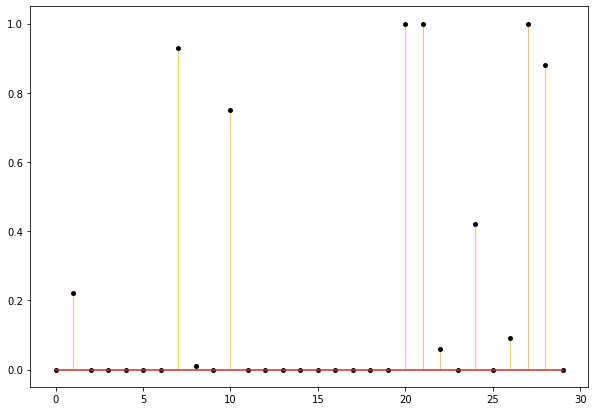

In [13]:
analysis.plot_selection_frequency()

**Regarding $\tau_{2}$ and $\tau_{3}$**

One has to keep in mind though, that a feature may be selected by elastic net (i.e. the weight i non-zero), but it may be:

1. very small and hence not very influential to the model (even though it was selected by elastic net)
2. alternating its sign (positive or negative weight value) across the ensemble of models, indicating unstable importance of this feature.

To get more detailed information on the weight sizes one could investigate the full distribution of the weights of each feature across all models. This is possible by calling `.get_weight_distributions()`. This returns an array holding all weights across all models in the ensemble (rows) and each feature (columns). Here we can see that for the feature at index 5 `mean compactness` the weights are always 0 across all 100 models applied in this example (corresponding to the plot above). 

In [14]:
analysis.get_weight_distributions()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
K(1),0.0,0.000000,0.0,0.0,0.0,0.0,0.0,-0.435280,0.000000,0.0,-0.496430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.277519,-0.390974,0.000000,0.0,0.000000,0.0,-0.338998,-0.946106,-0.159163,0.0
K(2),0.0,0.000000,0.0,0.0,0.0,0.0,0.0,-0.554566,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.777369,-0.377554,0.000000,0.0,-0.009266,0.0,0.000000,-1.051652,-0.205971,0.0
K(3),0.0,0.000000,0.0,0.0,0.0,0.0,0.0,-0.532470,0.000000,0.0,-0.160261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.661172,-0.536638,0.000000,0.0,0.000000,0.0,0.000000,-0.849285,-0.200873,0.0
K(4),0.0,-0.059827,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,-0.398930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.601397,-0.457772,0.000000,0.0,0.000000,0.0,0.000000,-1.366384,-0.109082,0.0
K(5),0.0,0.000000,0.0,0.0,0.0,0.0,0.0,-0.308239,0.000000,0.0,-0.144496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.547900,-0.472164,0.000000,0.0,-0.093910,0.0,0.000000,-1.320491,0.000000,0.0
K(6),0.0,0.000000,0.0,0.0,0.0,0.0,0.0,-0.160104,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.901037,-0.433418,0.000000,0.0,-0.066431,0.0,0.000000,-1.230276,-0.236696,0.0
K(7),0.0,0.000000,0.0,0.0,0.0,0.0,0.0,-0.108197,0.000000,0.0,-0.190997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.633191,-0.385425,0.000000,0.0,-0.083414,0.0,0.000000,-1.496247,-0.117313,0.0
K(8),0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,-0.329091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.643406,-0.422121,0.000000,0.0,0.000000,0.0,0.000000,-1.316066,-0.198559,0.0
K(9),0.0,-0.153161,0.0,0.0,0.0,0.0,0.0,-0.115867,0.000000,0.0,-0.276701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.663727,-0.371543,0.000000,0.0,-0.081423,0.0,0.000000,-1.219621,-0.052945,0.0
K(10),0.0,-0.188811,0.0,0.0,0.0,0.0,0.0,-0.366656,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.526036,-0.229774,0.000000,0.0,0.000000,0.0,0.000000,-1.459007,-0.103124,0.0


We assign this array to a variable and plot weight distributions of specific feautures using histograms

In [15]:
weight_dist = analysis.get_weight_distributions()

Plot the weight distribution of feature at index 27, that is `worst concave points`. This feature is selected very often as we can see that most of the weights are different from zero and negative.

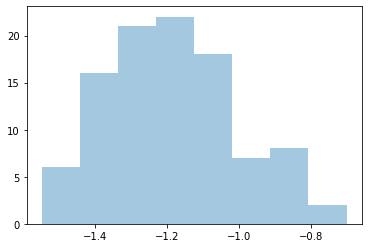

In [16]:
import seaborn as sns
ax = sns.distplot(weight_dist.values[:, 27], kde=False)

All of the weights of feature at index 23 (`worst area`) are zero, meaning that this feature is not important for the model.

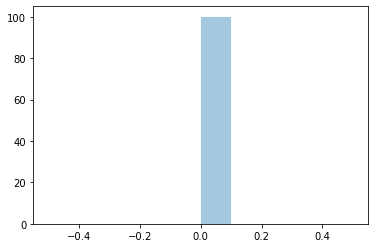

In [17]:
ax = sns.distplot(weight_dist.values[:, 23], kde=False)

### Investigation of class predictions

Since we use an ensemble of models, we can predict the class of the validations samples during the RENT process. We can get more details by calling `.summery_objects()` which will return a data frame holding all predictions.

In the example below we can see that patient 489 was 25 times (out of K=100 models in the ensemble) in the validation set (column `# test`). That means we get 25 predictions from 25 unique models and investigate how well predictions worked for this patient. Patient 489 belongs to class 0 (column `class`) and was predictied incorrectly 25 times (column `# incorrect`) out of 25 predictions, which results in 100% incorrect classifications (column `% incorrect`). 

Looking at this dataframe we can see that most of the patients were predicted correctly every time, however, there are some patients that were predicted incorrectly every time (patients 38, 135, 81, 255, 297, 73, 40, 13, 86, 41). It might be worth investigating why it is so difficult predict the correct class for these patients by comparing them to patients from the same class that are predicted correctly most or all of the times. We will do this using PCA further below in this notebook.  

In [18]:
analysis.summary_objects()

,# test,class,# incorrect,% incorrect
293,27,1,0,0.000000
332,17,1,0,0.000000
565,25,0,0,0.000000
278,20,1,0,0.000000
489,29,0,29,100.000000
346,27,1,0,0.000000
357,20,1,0,0.000000
355,24,1,0,0.000000
112,24,1,4,16.666667
68,28,1,1,3.571429


We can also extract the class probabilities for each prediction by calling `.get_object_probabilities`.

In [19]:
analysis.get_object_probabilities()

,K(1),K(2),K(3),K(4),K(5),K(6),K(7),K(8),K(9),K(10),K(11),K(12),K(13),K(14),K(15),K(16),K(17),K(18),K(19),K(20),K(21),K(22),K(23),K(24),K(25),K(26),K(27),K(28),K(29),K(30),K(31),K(32),K(33),K(34),K(35),K(36),K(37),K(38),K(39),K(40),K(41),K(42),K(43),K(44),K(45),K(46),K(47),K(48),K(49),K(50),K(51),K(52),K(53),K(54),K(55),K(56),K(57),K(58),K(59),K(60),K(61),K(62),K(63),K(64),K(65),K(66),K(67),K(68),K(69),K(70),K(71),K(72),K(73),K(74),K(75),K(76),K(77),K(78),K(79),K(80),K(81),K(82),K(83),K(84),K(85),K(86),K(87),K(88),K(89),K(90),K(91),K(92),K(93),K(94),K(95),K(96),K(97),K(98),K(99),K(100)
293,NaN,NaN,NaN,0.926747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.926959,NaN,NaN,0.923538,0.922066,NaN,NaN,NaN,NaN,NaN,NaN,0.911054,0.935550,9.250594e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.920313,NaN,0.933772,NaN,0.927218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.920465,0.922049,NaN,0.928332,0.921523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.921582,NaN,0.923618,0.924279,NaN,0.930253,0.924528,0.921986,NaN,0.930117,0.923317,0.932060,0.926172,NaN,NaN,NaN,0.911079,0.933137,0.919421,NaN,NaN,NaN,NaN,NaN
332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.982405,NaN,NaN,0.987890,NaN,NaN,NaN,0.983642,NaN,NaN,0.980245,NaN,NaN,NaN,NaN,NaN,0.988791,0.981905,NaN,NaN,NaN,NaN,NaN,0.984859,0.985782,NaN,NaN,NaN,0.982630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.983941,0.988481,0.985313,0.982043,NaN,NaN,NaN,NaN,NaN,NaN,0.986185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.987172,NaN,NaN,NaN,NaN,0.988521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.985982,NaN
565,0.016345,0.019029,0.012345,NaN,0.018369,NaN,NaN,NaN,NaN,NaN,NaN,0.012517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.012298,NaN,NaN,NaN,NaN,0.019281,NaN,NaN,NaN,NaN,NaN,NaN,0.020520,NaN,NaN,0.011480,0.014139,NaN,NaN,NaN,NaN,NaN,NaN,0.010064,NaN,NaN,NaN,NaN,0.014766,NaN,NaN,NaN,NaN,NaN,NaN,0.013994,0.011647,NaN,NaN,NaN,NaN,NaN,0.021989,0.016953,NaN,NaN,NaN,NaN,0.008516,NaN,0.014452,NaN,0.018738,NaN,NaN,NaN,0.015735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.020332,NaN,NaN,NaN,0.016677,NaN,NaN,0.013343,0.019362,NaN,NaN,NaN,NaN,0.011543,NaN,NaN
278,NaN,NaN,NaN,NaN,NaN,0.932526,NaN,0.927703,0.927430,NaN,NaN,NaN,NaN,0.926751,NaN,0.939755,NaN,0.928331,NaN,NaN,NaN,NaN,0.928136,NaN,0.920180,NaN,9.420037e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.925078,NaN,NaN,NaN,NaN,NaN,0.929253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.938917,NaN,NaN,NaN,NaN,0.925778,0.933951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.931439,NaN,NaN,NaN,0.942045,NaN,NaN,0.926071,NaN,NaN,NaN,0.937341,NaN,NaN,NaN,NaN,NaN,NaN,0.935125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.926410,NaN,NaN,NaN
489,NaN,NaN,NaN,NaN,0.679039,NaN,0.594187,NaN,NaN,0.592233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.679695,0.633224,NaN,NaN,NaN,0.608991,NaN,NaN,NaN,0.665940,NaN,NaN,NaN,NaN,0.644281,NaN,0.595805,0.637236,0.651446,NaN,NaN,0.755803,NaN,NaN,NaN,0.638761,NaN,0.617460,0.606087,NaN,0.635423,NaN,NaN,NaN,NaN,NaN,0.575101,NaN,NaN,NaN,NaN,0.593450,NaN,NaN,0.592069,0.720441,0.728312,0.626821,NaN,0.516598,0.641214,NaN,NaN,0.629665,NaN,0.694329,NaN,NaN,NaN,NaN,0.522423,NaN,0.682560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.620267,NaN
346,NaN,NaN,NaN,0.955425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.957535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.962278,0.951674,0.948798,NaN,NaN,0.962085,NaN,NaN,NaN,NaN,0.957451,NaN,0.962530,NaN,NaN,NaN,0.955318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.961769,NaN,NaN,NaN,0.962977,NaN,0.961394,0.959529,0.955133,NaN,NaN,NaN,0.957043,NaN,0.963109,0.957552,0.954992,NaN,NaN,NaN,NaN,NaN,0.952449,NaN,0.955854,0.957429,NaN,NaN,0.963041,0.962212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.955645,NaN,NaN,NaN,NaN,NaN,0.960642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.959250,NaN,0.956224,NaN,NaN
357,NaN,NaN,0.919100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.935271,NaN,NaN,NaN,0.931573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.924215,0.950926,9.458422e-01,0.925769,NaN,0.932253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.933983,NaN,NaN,NaN,NaN,0.935314,0.940813,NaN

We can plot the class probabilities for one or more patients by calling `.plot_object_probabilities` and investigate how difficult it was to classify the patients correctly. Patient 291 belongs to class 1 and the class probabilities are mostly just above the threshold of 0.5 and below for roughly 13% of the predictions. For patient 91, who belongs to class 0, 32% of the class probabilities indicate incorrectly that this patient belongs to class 1. Patients 253 (class 0) and 150 (class 1) were always predicted correctly and their respective probabilities close to the truth. 

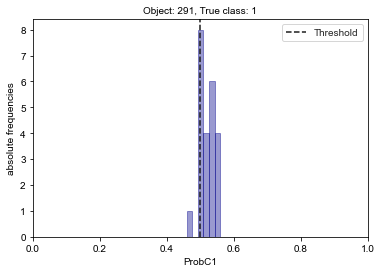

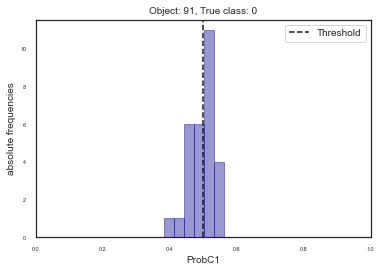

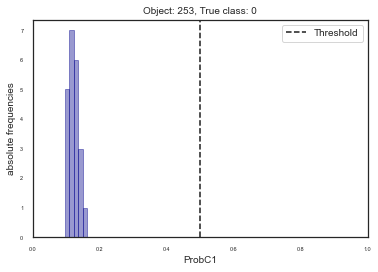

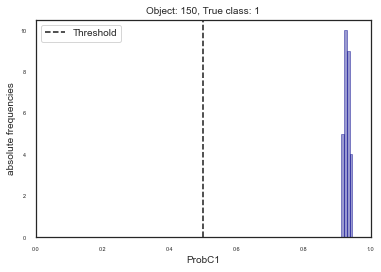

In [20]:
analysis.plot_object_probabilities(object_id=[291, 91, 253, 150])

We can apply PCA (principal component analysis) either on each class separately or both. 

**Example below: PCA on class 0**

* First plot: *PCA scores* plot with coloured scores showing distribution of the patients for the first two components.

Each point represents one patient in the class. The darker the colour, the more often the patient was classified incorrectly. The coloring degree is set by the value in column `% incorrect` in the array above that we got when calling `.summary_objects`. When applying PCA to class 0 we can see that those patients often classified incorrectly are grouped on the left side of the scores plot, indicating that they are similiar in some way.  

* Second plot: *PCA scores* plot - same as first plot, now showing patient ID

We can see that the first component explains 34.7% of the total variance in the data based on the four selected features, while the second component explains 30.0%. That means that the first and second component together explain 67.7% of all the total variance. We have caputred much of the systematic information with these two components, however more systematic information may be containten in further componen, i.e. component 3, 4 and so on. One has to keep in mind though, the explained variance is smaller for each following component.

* Third plot: *PCA loadings* plot showing how features contributed to the variance in the data

The four selected features are all located on the right side of the plot. When superimposing the PCA scores plot on PCA loadings plot we can say the following: patients in close proximity of the features have high values for those features. Patients on the opposite side have low values for those features. From the two plots we can say that the misclassified patients had relatively low values for the selected features. 

* Fourth plot: *PCA correlation loadings* plot - similar to *PCA loadings* plot, but showing how much of the variance is explained in each feature

We can see that the variance in features `worst radius`, `worst concave points` and `worst symmetry` is explained almost entirely by component 1 and 2, since they are located close to the outer ring that represents 100% explained variance. The inner ring represents 50% explained variance. For feature `worst concave points` almost all of the explained variance is captured by component 1. For features `worst radius` and `worst symmetry` it is the combination of component 1 and 2 that contribute to explaining close to 100% of the variance. Feature `worst texture` is now well explained by component 1 and 2, meaning that some of its systematic variance may be explained by component 3 or further.  

* Fifth plot: *PCA bi-plot* - superimposed *PCA scores* and *PCA loadings*

This plot is actually the PCA scores and PCA loadings superimposed.

* Sixth plot: *PCA explained variance*

From this plot we can see the cumulative explained variance across an increasing number of components. The blue line represents the calibrated explained variance, while the red line represents the validated explained variance. The red line being close to the blue line indicates that all components in the model are valid and may be used for interpretation. We also see that four components explain 100% of all variance in the data. This is not surprising, since we have exactly 4 features in the the data (the four features that were selected by RENT).

loo


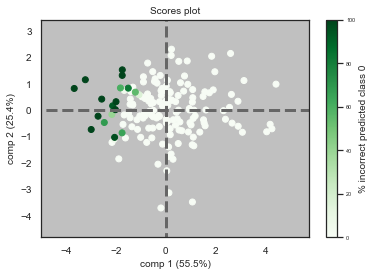

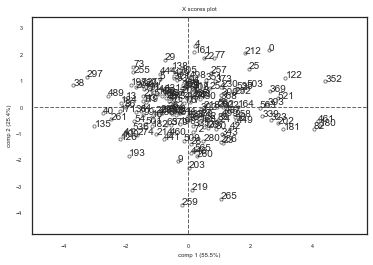

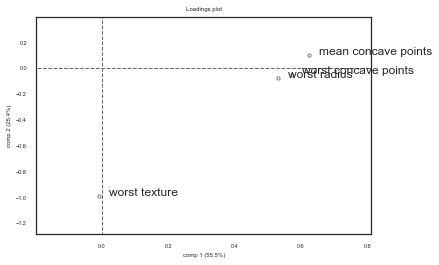

In [21]:
analysis.plot_object_PCA(cl=0)

**Example below: PCA on class 1**

* First plot: *PCA scores plot* with colouring

We can see that only few samples are coloured darker because of misclassification. 

loo


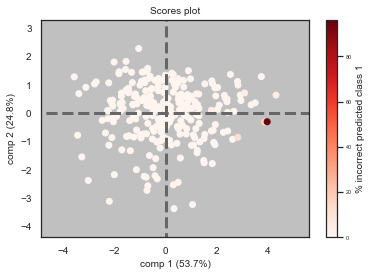

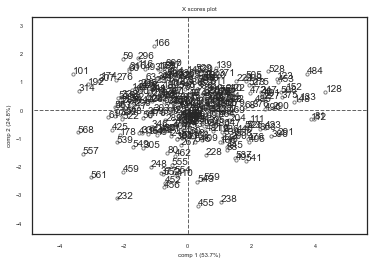

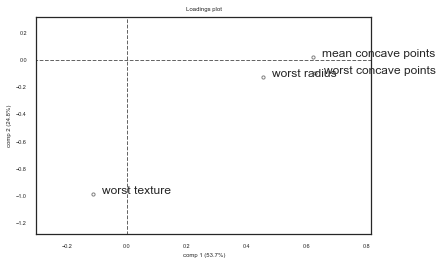

In [22]:
analysis.plot_object_PCA(cl=1)

**Example below: PCA on class 0 and class 1 together**

* First plot: *PCA scores* plot with coloured scores

We can see that most of the misclassified samples would lie along the dicision boundary (not shown) that separates the two classes. Circles represent class 0, while stars represent class 1.

loo


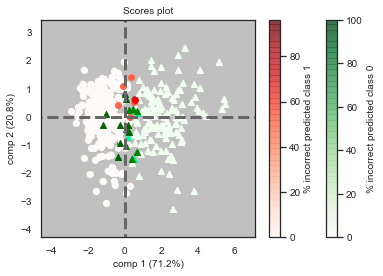

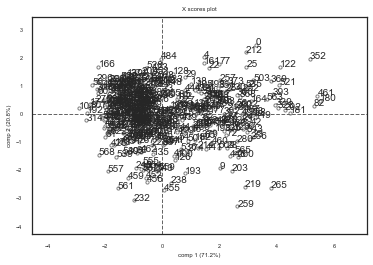

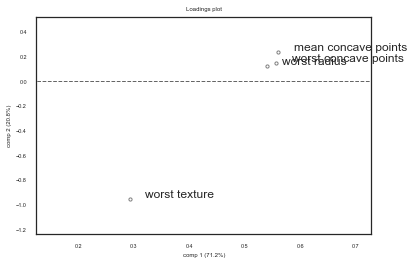

In [23]:
analysis.plot_object_PCA(cl='both')

### Check performance using only selected features

RENT selected some features based on the distribution of the weights of each feature across the ensenmble of models. Now let's check how well a model performs that uses only the selected features on unseen data, i.e data that has not been touched by the RENT method. 

In [24]:
#predict test data

# Import what is needed for prediction and evaluation of predictions from test set
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression as LR

# Scale the data accordingly
sc = StandardScaler()
train_data_sc = sc.fit_transform(train_data.iloc[:, selected_features])
test_data_sc = sc.transform(test_data.iloc[:, selected_features])

# Train model with 
model = LR(penalty='none', max_iter=8000, solver="saga", random_state=0).\
        fit(train_data_sc, train_labels)

# Print results
print("f1 1: ", f1_score(test_labels, model.predict(test_data_sc)))
print("f1 0: ", f1_score(1 - test_labels, 1 - model.predict(test_data_sc)))
print("Accuracy: ", accuracy_score(test_labels, model.predict(test_data_sc)))
print("Matthews correlation coefficient: ", matthews_corrcoef(test_labels, model.predict(test_data_sc)))


f1 1:  0.9832402234636872
f1 0:  0.9719626168224299
Accuracy:  0.9790209790209791
Matthews correlation coefficient:  0.9553116797597819


Since the classes in the Wisconsin breast cancer data set are easy to separate, we achieve high performance for the test data.

### Feasibility study regarding the features selected by RENT

In order to validate the selected features we benefit to know whether the selected features provide models that perform better than random. This can be done in two complimentary ways:

1. randomly draw the same number of features from the full set of features and compute model performance on the test data. Do this many times and collect model performances. Compute average performance across these models and check how many of those are higher than the performance of the selected features. One should expect that the average performance of the models with randomly drawn features would be substantially lower than the performance of the model with the selected features. One should also expect that the number of performances with randomly drawn features higher than the performance of the model with the selected features should be quite low. Say, if 4 out of 100 models with randomly drawn features are higher than the performance with the selected features, this would result in a p-value 4 / 100 = 0.04. It is up to the user where to set the required significance level.

2. permute the lables of the test data and compute model performance using the selected features every time. In the same manner as in point 1 above, collect the performances based on permuted labels and compute average performance. One should expect that the average performance for the models with permuted labels should be substantially lower. Also as in 1. one can compute the p-value from the permutation based model performances by checking how many of the models provided higher performance than the model using the original lables without permutation.

A nice source on these permuation based p-values is provideded [here](https://www.jwilber.me/permutationtest/ )

VS1: p-value for average score from random feature drawing:  0.01
With a significancelevel of  0.05  H0 is rejected.
 
-------------------------------------------------
 
VS2: p-value for score from permutation of test labels:  0.0
With a significancelevel of  0.05  H0 is rejected.


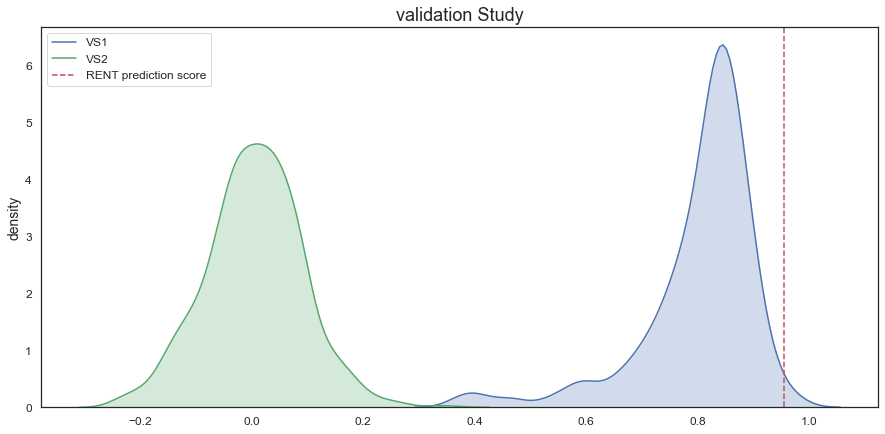

In [25]:
analysis.validation_study(test_data, test_labels, num_drawings=100, num_permutations=1000, alpha=0.05)

From the plot above and the computed p-values we can conclude that the test performance with the selected features is:

* significantly better than the average prediction performance from randomly drawn features from the full set of features
* significantly better than the average prediction performance from models with permuted test labels

This means we can be confident that we have selected relevant and important features for the model.